# T-cell response model evaluation
This notebook contains the code to generate the figures for the evaluation of the T-cell response model and the benchmark against existing models.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, roc_auc_score
import scipy.stats

In [3]:
# load the evaluation scripts from the code directory, which are also used during training
%load ../code/evaluation.py

## Plotting helper functions

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
rcParams['axes.titlepad'] = 15
rcParams.update({'font.size': 17})

In [5]:
def hplot_results(results, metric, title, size, aggregation='mean', x_pos=None, y_lim=None, err_bars=True, err_text=False, label_rotation=0, text_shift=0.005, vline=None, display_sizes=True, display_text=True, color=None, strength=0.8, hide_xticklabels=False):
    results_r = list(reversed(results))
    # results = [(x_label, eval_type, results_dict), ...]
    x_pos = list(range(len(results_r))) if x_pos is None else x_pos
    if display_sizes:
        x_labels = [f"{x_label} - {result[metric][eval_type]['skipped_count']/(result[metric][eval_type]['skipped_count']+result[metric][eval_type]['count']):.0%} skipped" for x_label, eval_type, result in results_r]
    else:
        x_labels = [f"{x_label}" for x_label, eval_type, result in results_r]
        skipped_count_sum = sum([result[metric][eval_type]['skipped_count'] for _, eval_type, result in results_r if 'skipped_count' in result[metric][eval_type]])
        if skipped_count_sum > 0:
            # print(f'{skipped_count_sum} peptides have been skipped.')
            pass
    mean_scores = [results_dict[metric][eval_type][aggregation] for _, eval_type, results_dict in results_r]
    errs = [results_dict[metric][eval_type]['sem'] for _, eval_type, results_dict in results_r] if err_bars else None
    fig, ax = plt.subplots(figsize=size)
    ax.barh(x_pos, mean_scores, height=strength, xerr=errs, align='center', alpha=1, ecolor='black', capsize=8, color=color)
    ax.set_xlabel(metric)
    ax.set_yticks(x_pos)
    ax.set_yticklabels(x_labels, rotation=label_rotation)
    if hide_xticklabels:
        ax.set_xticks([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7])
        ax.set_xticklabels([])
    else:
        ax.set_xticks([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7])
        ax.set_xticklabels(['0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7'])
    ax.set_title(title)
    if metric == 'ROC AUC' and y_lim is None:
        ax.set_xlim(0.4, 0.9)
    elif y_lim is None:
        ax.set_xlim(0, 0.9)
    else:
        ax.set_xlim(y_lim)
    ax.xaxis.grid(True)
    for i in range(len(mean_scores)):
        text_pos = mean_scores[i] + text_shift
        if err_bars:
            text_pos += errs[i]
        if err_bars and err_text:
            text = f'{mean_scores[i]:.4f} ± {errs[i]:.3f}'
        else:
            text = f'{mean_scores[i]:.4f}'
        if display_text:
            plt.text(text_pos, x_pos[i], text, color='black', va='center', fontweight='bold', fontsize=20)
    if vline is not None:
        plt.axvline(x=vline, color='black', linewidth=1)
    plt.tight_layout()
    # plt.show()

In [21]:
def hplot_results_pairs(results_1, results_2, labels, metric, title, size, aggregation='mean', x_pos=None, y_lim=None, err_bars=True, err_text=False, label_rotation=0, text_shift=0.005, vline=None, legend_loc='upper right', display_text=True, legend=True, colors=('tab:blue', 'tab:green'), hide_xticklabels=False):
    results_1_list, results_1_label = results_1
    results_2_list, results_2_label = results_2
    results_1_list_r = list(reversed(results_1_list))
    results_2_list_r = list(reversed(results_2_list))
    labels_r = list(reversed(labels))
    # results_list = [(x_label, eval_type, results_dict), ...]
    y_pos = np.array(list(range(len(results_1_list))) if x_pos is None else x_pos)
    
    mean_scores_1 = [results_dict[metric][eval_type][aggregation] for _, eval_type, results_dict in results_1_list_r]
    mean_scores_2 = [results_dict[metric][eval_type][aggregation] for _, eval_type, results_dict in results_2_list_r]
    errs_1 = [results_dict[metric][eval_type]['sem'] for _, eval_type, results_dict in results_1_list_r] if err_bars else None
    errs_2 = [results_dict[metric][eval_type]['sem'] for _, eval_type, results_dict in results_2_list_r] if err_bars else None
    fig, ax = plt.subplots(figsize=size)
    height = 0.4
    color1, color2 = colors
    ax.barh(y_pos + height/2, mean_scores_1, height, xerr=errs_1, align='center', alpha=1, color=color1, ecolor='black', capsize=7, label=results_1_label)
    ax.barh(y_pos - height/2, mean_scores_2, height, xerr=errs_2, align='center', alpha=1, color=color2, ecolor='black', capsize=7, label=results_2_label)
    ax.set_xlabel(metric)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels_r, rotation=label_rotation)
    if hide_xticklabels:
        ax.set_xticklabels(['',]*len(list(ax.get_xticklabels())))
    ax.set_title(title)
    if metric == 'ROC AUC' and y_lim is None:
        ax.set_xlim(0.4, 0.9)
    elif y_lim is None:
        ax.set_xlim(0, 0.9)
    else:
        ax.set_xlim(y_lim)
    ax.xaxis.grid(True)
    for i in range(len(mean_scores_1)):
        text_pos_1 = mean_scores_1[i] + text_shift
        text_pos_2 = mean_scores_2[i] + text_shift
        if err_bars:
            text_pos_1 += errs_1[i]
            text_pos_2 += errs_2[i]
        if err_bars and err_text:
            text_1 = f'{mean_scores_1[i]:.3f} ± {errs_1[i]:.3f}'
            text_2 = f'{mean_scores_2[i]:.3f} ± {errs_2[i]:.3f}'
        else:
            text_1 = f'{mean_scores_1[i]:.3f}'
            text_2 = f'{mean_scores_2[i]:.3f}'
        if display_text:
            plt.text(text_pos_1, y_pos[i] + height/2 - 0.04, text_1, color='black', va='center', fontweight='bold', fontsize=19)
            plt.text(text_pos_2, y_pos[i] - height/2 - 0.04, text_2, color='black', va='center', fontweight='bold', fontsize=19)
    if vline is not None:
        plt.axvline(x=vline, color='black', linewidth=1)
    
    if legend:
        ax.legend(loc=legend_loc)
    
    plt.tight_layout()
    # plt.show()

In [22]:
def hplot_results_triples(results_1, results_2, results_3, labels, metric, title, size, aggregation='mean', x_pos=None, y_lim=None, err_bars=True, err_text=False, label_rotation=0, text_shift=0.005, vline=None, legend_loc='upper right', display_text=True, legend=True):
    results_1_list, results_1_label = results_1
    results_2_list, results_2_label = results_2
    results_3_list, results_3_label = results_3
    results_1_list_r = list(reversed(results_1_list))
    results_2_list_r = list(reversed(results_2_list))
    results_3_list_r = list(reversed(results_3_list))
    labels_r = list(reversed(labels))
    # results_list = [(x_label, eval_type, results_dict), ...]
    y_pos = np.array(list(range(len(results_1_list))) if x_pos is None else x_pos)
    
    mean_scores_1 = [results_dict[metric][eval_type][aggregation] for _, eval_type, results_dict in results_1_list_r]
    mean_scores_2 = [results_dict[metric][eval_type][aggregation] for _, eval_type, results_dict in results_2_list_r]
    mean_scores_3 = [results_dict[metric][eval_type][aggregation] for _, eval_type, results_dict in results_3_list_r]
    errs_1 = [results_dict[metric][eval_type]['sem'] for _, eval_type, results_dict in results_1_list_r] if err_bars else None
    errs_2 = [results_dict[metric][eval_type]['sem'] for _, eval_type, results_dict in results_2_list_r] if err_bars else None
    errs_3 = [results_dict[metric][eval_type]['sem'] for _, eval_type, results_dict in results_3_list_r] if err_bars else None
    fig, ax = plt.subplots(figsize=size)
    height = 0.3
    ax.barh(y_pos + height, mean_scores_1, height, xerr=errs_1, align='center', alpha=1, ecolor='black', capsize=7, label=results_1_label)
    ax.barh(y_pos, mean_scores_2, height, xerr=errs_2, align='center', alpha=1, ecolor='black', capsize=7, label=results_2_label)
    ax.barh(y_pos - height, mean_scores_3, height, xerr=errs_3, align='center', alpha=1, ecolor='black', capsize=7, label=results_3_label)
    ax.set_xlabel(metric)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels_r, rotation=label_rotation)
    ax.set_title(title)
    if metric == 'ROC AUC' and y_lim is None:
        ax.set_xlim(0.4, 0.9)
    elif y_lim is None:
        ax.set_xlim(0, 0.9)
    else:
        ax.set_xlim(y_lim)
    ax.xaxis.grid(True)
    for i in range(len(mean_scores_1)):
        text_pos_1 = mean_scores_1[i] + text_shift
        text_pos_2 = mean_scores_2[i] + text_shift
        text_pos_3 = mean_scores_3[i] + text_shift
        if err_bars:
            text_pos_1 += errs_1[i]
            text_pos_2 += errs_2[i]
            text_pos_3 += errs_3[i]
        if err_bars and err_text:
            text_1 = f'{mean_scores_1[i]:.3f} ± {errs_1[i]:.3f}'
            text_2 = f'{mean_scores_2[i]:.3f} ± {errs_2[i]:.3f}'
            text_3 = f'{mean_scores_3[i]:.3f} ± {errs_3[i]:.3f}'
        else:
            text_1 = f'{mean_scores_1[i]:.3f}'
            text_2 = f'{mean_scores_2[i]:.3f}'
            text_3 = f'{mean_scores_3[i]:.3f}'
        if display_text:
            plt.text(text_pos_1, y_pos[i] + height, text_1, color='black', va='center', fontweight='bold', fontsize=19)
            plt.text(text_pos_2, y_pos[i], text_2, color='black', va='center', fontweight='bold', fontsize=19)
            plt.text(text_pos_3, y_pos[i] - height, text_3, color='black', va='center', fontweight='bold', fontsize=19)
    if vline is not None:
        plt.axvline(x=vline, color='black', linewidth=1)
    
    if legend:
        ax.legend(loc=legend_loc)
    
    plt.tight_layout()
    # plt.show()

## Evaluation functions for computing cross-validation results

In [12]:
def read_valid_results(experiment_name, outer_fold=None):
    results_dir = f'../valid_results_cv/{experiment_name}'
    df_list = []
    for result_file in os.listdir(results_dir):
        if '.pkl' in result_file:
            inner_fold = result_file[-5]
            df = pd.read_pickle(results_dir + '/' + result_file)
            df['inner_fold'] = inner_fold
            df_list.append(df)
    results_df = pd.concat(df_list)
    if outer_fold is not None:
        results_df = results_df.loc[results_df['outer_fold'] == outer_fold]
    return results_df

In [13]:
def read_test_results(experiment_name, outer_fold=None):
    results_dir = f'../test_results/{experiment_name}'
    df_list = []
    for result_file in os.listdir(results_dir):
        if '.pkl' in result_file:
            df = pd.read_pickle(results_dir + '/' + result_file)
            df_list.append(df)
    results_df = pd.concat(df_list)
    return results_df

In [4]:
def combine_fold_results(results_list):
    combined_dict = {}
    for result_dict in results_list:
        outer_fold = result_dict['outer_fold']
        for eval_type, fold_result in result_dict.items():
            if eval_type != 'outer_fold':
                fold_result['outer_fold'] = outer_fold
                combined_dict.setdefault(eval_type, []).append(fold_result)
    combined_results = {'ROC AUC': {}, 'AP': {}}
    for metric in combined_results.keys():
        for eval_type, fold_results in combined_dict.items():
            instance_count = sum([results['count'] for results in fold_results])
            skipped_instance_count = sum([results['skipped_count'] for results in fold_results])
            if instance_count == 0:
                weighted_mean, mean, sem = None, None, None
                per_fold_results = {}
            else:
                weighted_mean = sum([results[metric] * results['count'] for results in fold_results if results['count'] > 0]) / instance_count
                mean = np.mean([results[metric] for results in fold_results if results['count'] > 0])
                sem = scipy.stats.sem([results[metric] for results in fold_results if results['count'] > 0])
                per_fold_results = {f'fold_{results["outer_fold"]}': results[metric] for results in fold_results}
            combined_results[metric][eval_type] = {**per_fold_results, 'mean': mean, 'weighted_mean': weighted_mean, 'sem': sem, 'count': instance_count, 'skipped_count': skipped_instance_count}
    return combined_results

In [16]:
def get_parameter_set(results_df, best_result, hyperparams):
    value_counts = results_df.nunique()
    variable_params = value_counts.loc[value_counts > 1].index
    parameter_selection_string = ''
    parameter_selection = {}
    for param in set(variable_params) & set(hyperparams):
        param_values = ', '.join(map(str, results_df[param].unique()))
        parameter_selection_string += f'{param}: {param_values} -> {best_result["params"][param]}\n\n'
        parameter_selection[param] = best_result["params"][param]
    return parameter_selection_string, parameter_selection

In [17]:
def get_param_sensitivity(results_df, group_by, selected_metric, hyperparams):
    value_counts = results_df.nunique()
    variable_params = set(value_counts.loc[value_counts > 1].index) & set(hyperparams)
    sensitivity_dict = {}
    for variable_param in variable_params:
        grouped_results = results_df.groupby([variable_param])
        sensitivity_dict[variable_param] = {}
        for param_value, df in grouped_results:
            best_result = df.loc[df[selected_metric].idxmax()]
            sensitivity_dict[variable_param][best_result[variable_param]] = {
                'score': best_result[selected_metric], 'sem': best_result[f'SEM - {selected_metric}']}
    return sensitivity_dict

In [18]:
def get_best_param_sensitivity(results_df, best_result, selected_metric, hyperparams):
    value_counts = results_df.nunique()
    variable_params = list(set(value_counts.loc[value_counts > 1].index) & set(hyperparams))
    sensitivity_dict = {}
    best_result_params = best_result[variable_params].values
    for i in range(len(variable_params)):
        variable_param = variable_params[i]
        sensitivity_dict[variable_param] = {}
        best_result_param = best_result[variable_params].values
        variable_param_values = results_df[variable_param].unique()
        for param_value in variable_param_values:
            best_result_param[i] = param_value
            selected_result = results_df.loc[(results_df[variable_params].values == best_result_param).all(1)]
            if len(selected_result) == 1:
                selected_result = selected_result.iloc[0]
                sensitivity_dict[variable_param][param_value] = {
                    'score': selected_result[selected_metric], 'sem': selected_result[f'SEM - {selected_metric}']}
            else:
                print(f'selected_result for {variable_param}: {param_value} has {len(selected_result)} entries')
    return sensitivity_dict

In [19]:
def get_result_dict(result_series):
    overall_result_dict = result_series.to_dict()
    result_dict = {eval_type: result for eval_type, result in overall_result_dict.items() if 'ROC AUC' in eval_type or 'AP' in eval_type}
    param_dict = {param: value for param, value in overall_result_dict.items() if 'ROC AUC' not in param and 'AP' not in param}
    results = {'params': param_dict, 'ROC AUC': {}, 'AP': {}}
    for eval_type_combined, result in result_dict.items():
        if 'ROC AUC' in eval_type_combined:
            eval_type = eval_type_combined.replace('ROC AUC - ', '')
            metric = 'ROC AUC'
        else:
            eval_type = eval_type_combined.replace('AP - ', '')
            metric = 'AP'
        
        if eval_type_combined.startswith(f'Count - {metric}'):
            eval_type = eval_type.replace('Count - ', '')
            results[metric].setdefault(eval_type, {})
            results[metric][eval_type]['count'] = result
        elif eval_type_combined.startswith(f'SEM - {metric}'):
            eval_type = eval_type.replace('SEM - ', '')
            results[metric].setdefault(eval_type, {})
            results[metric][eval_type]['sem'] = result
        elif eval_type_combined.startswith(f'Skipped count - {metric}'):
            eval_type = eval_type.replace('Skipped count - ', '')
            results[metric].setdefault(eval_type, {})
            results[metric][eval_type]['skipped_count'] = result
        elif eval_type_combined.startswith(metric):
            results[metric].setdefault(eval_type, {})
            results[metric][eval_type]['mean'] = result
    return results                                                                                 

In [24]:
# best hyperparams per subset as input
# take mean over random seeds
# combine subsets
# take mean over folds

def get_inner_cv_results(results_df, average_over=['random_seed'], subset_selection=None, group_by=None):
    results_df = results_df.dropna(axis=1, how='all')
    value_counts = results_df.nunique()
    variable_params = value_counts.loc[value_counts > 1].index
    hyperparams = [col for col in results_df.columns
                   if 'ROC AUC -' not in col and 'AP -' not in col and 'Loss/' not in col and 'loss/' not in col and 'early_stop_epochs' not in col
                   and '_file' not in col and '_dir' not in col and col != 'config_id' and col != 'training_time'
                   and col not in average_over and col != 'description']
    result_metrics = [col for col in results_df.columns if 'ROC AUC -' in col or 'AP -' in col or col == 'early_stop_epochs']
    count_metrics = [col for col in results_df.columns if 'Count - ' in col]
    
    hyperparams = results_df[hyperparams].columns[~results_df[hyperparams].isna().any()].tolist()
    group_by_params = hyperparams
        
    # select subset based on hyperparameters
    if subset_selection is not None:
        attribute, value = subset_selection
        results_df = results_df.loc[results_df[attribute] == value]
    
    # take the mean over all inner folds with the same configuration
    grouped_results = results_df.groupby(group_by_params)
    mean_results_list = []
    for _, df in grouped_results:
        mean_results = df[result_metrics].mean()
        aggregated_params = df[group_by_params].iloc[0]
        result_series = pd.concat([aggregated_params, mean_results])
        mean_results_list.append(result_series)
    
    seed_avg_results = pd.DataFrame(mean_results_list, columns=group_by_params+result_metrics)

    # take the mean over the random folds
    group_by_params.remove('inner_fold')
    sem_names = [f'SEM - {metric}' for metric in result_metrics]
    count_sum_names = [f'SUM - {metric}' for metric in count_metrics]
    mean_results_list = []
    grouped_results = seed_avg_results.groupby(group_by_params)
    for _, df in grouped_results:
        mean_results = df[result_metrics].mean()
        sem = df[result_metrics].sem(axis=0)
        sem.index = sem_names
        count_sum = df[count_metrics].sum(axis=0)
        count_sum.index = count_sum_names
        aggregated_params = df[group_by_params].iloc[0]
        result_series = pd.concat([aggregated_params, mean_results, sem, count_sum])
        mean_results_list.append(result_series)
    fold_avg_results = pd.DataFrame(mean_results_list, columns=group_by_params+result_metrics+sem_names+count_sum_names)
    
    # select best hyperparameter combination
    # selected_metric = 'ROC AUC - MHC I+II - MHC+source corrected - no defaults/Validation
    
    if group_by is not None:
        grouped_results = fold_avg_results.groupby(group_by)
        best_results = {}
        for param_value, df in grouped_results:
            selected_metrics = [metric for metric in set(df.dropna(axis=1, how='all').columns) & set(result_metrics) if 'Selected metric' in metric]
            if len(selected_metrics) != 1:
                print(selected_metrics)
            selected_metric = selected_metrics[0]
            best_result_df = df.loc[df[selected_metric].idxmax()]
            best_result_dict = get_result_dict(best_result_df)
            param_set_string, param_set = get_parameter_set(fold_avg_results, best_result_dict, group_by_params)
            best_result_dict['param_set_string'] = param_set_string
            best_result_dict['param_set'] = param_set
            
            param_sensitivity = get_param_sensitivity(df, group_by_params, selected_metric, hyperparams)
            best_param_sensitivity = get_best_param_sensitivity(df, best_result_df, selected_metric, set(hyperparams)-set(group_by))
            best_result_dict['param_sensitivity'] = param_sensitivity
            best_result_dict['best_param_sensitivity'] = best_param_sensitivity
            best_result_dict['selected_metric'] = selected_metric
            
            best_result_dict['df'] = best_result_df
            best_result_params = best_result_df[group_by_params].values
            best_result_dict['seed_avg_df'] = seed_avg_results.loc[(seed_avg_results[group_by_params].values == best_result_params).all(1)]
            
            
            best_results[param_value] = best_result_dict
        return best_results
    else:
        selected_metrics = [metric for metric in set(fold_avg_results.dropna(axis=1, how='all').columns) & set(result_metrics) if 'Selected metric' in metric]
        if len(selected_metrics) != 1:
            print(selected_metrics)
        selected_metric = selected_metrics[0]
        best_result_df = fold_avg_results.loc[fold_avg_results[selected_metric].idxmax()]
        best_result_dict = get_result_dict(best_result_df)
        param_set_string, param_set = get_parameter_set(fold_avg_results, best_result_dict, group_by_params)
        param_sensitivity = get_param_sensitivity(fold_avg_results, group_by_params, selected_metric, hyperparams)
        best_param_sensitivity = get_best_param_sensitivity(fold_avg_results, best_result_df, selected_metric, hyperparams)
        best_result_dict['param_sensitivity'] = param_sensitivity
        best_result_dict['best_param_sensitivity'] = best_param_sensitivity
        best_result_dict['param_set_string'] = param_set_string
        best_result_dict['param_set'] = param_set
        best_result_dict['selected_metric'] = selected_metric
        return best_result_dict

In [107]:
# best hyperparams per subset as input
# take mean over random seeds
# combine subsets
# take mean over folds

def combine_test_results(results_df, per_fold=False):
    results_df = results_df.dropna(axis=1, how='all')
    value_counts = results_df.nunique()
    variable_params = value_counts.loc[value_counts > 1].index
    hyperparams = [col for col in results_df.columns
                   if 'ROC AUC -' not in col and 'AP -' not in col and 'Loss/' not in col and 'loss/' not in col and 'early_stop_epochs' not in col
                   and '_file' not in col and '_dir' not in col and col != 'config_id' and col != 'training_time'
                   and col != 'description' and col != 'random_seed']
    result_metrics = [col for col in results_df.columns if 'ROC AUC -' in col or 'AP -' in col or col == 'early_stop_epochs']
    count_metrics = [col for col in results_df.columns if 'Count - ' in col]
    
    hyperparams = results_df[hyperparams].columns[~results_df[hyperparams].isna().any()].tolist()
    group_by_params = hyperparams + ['model_file']
            
    # take the mean over random seeds
    grouped_results = results_df.groupby(group_by_params)
    
    # print('group_by_params', group_by_params)
    mean_results_list = []
    for _, df in grouped_results:
        # print(len(df))
        mean_results = df[result_metrics].mean()
        aggregated_params = df[group_by_params].iloc[0]
        result_series = pd.concat([aggregated_params, mean_results])
        mean_results_list.append(result_series)
    
    # print('len(mean_results_list)', len(mean_results_list))
    seed_avg_results = pd.DataFrame(mean_results_list, columns=group_by_params+result_metrics)

    # print(seed_avg_results['ROC AUC - MHC I - MHC+source corrected - no defaults/Validation'].isna().sum())
    transformed_dicts = [transform_dict(get_result_dict(seed_avg_results.iloc[i])) for i in range(len(seed_avg_results))]
    
    if per_fold:
        return transformed_dicts
    
    return combine_fold_results(transformed_dicts)
    
    # take the mean over the random folds
    sem_names = [f'SEM - {metric}' for metric in result_metrics]
    count_sum_names = [f'SUM - {metric}' for metric in count_metrics]
    
    mean_results = seed_avg_results[result_metrics].mean()
    print(seed_avg_results['ROC AUC - MHC I - MHC corrected - Human subset - no defaults/Test'].values)
    sem = df[result_metrics].sem(axis=0)
    sem.index = sem_names
    count_sum = df[count_metrics].sum(axis=0)
    count_sum.index = count_sum_names
    aggregated_params = df[group_by_params].iloc[0]
    result_series = pd.concat([aggregated_params, mean_results, sem, count_sum])
        
    test_result_dict = get_result_dict(result_series)
    
    return test_result_dict

In [26]:
def transform_dict(result_dict):
    new_dict = {}
    for key in result_dict['ROC AUC'].keys():
        new_dict[key] = {}
        new_dict[key]['ROC AUC'] = result_dict['ROC AUC'][key]['mean']
        new_dict[key]['AP'] = result_dict['AP'][key]['mean']
        new_dict[key]['count'] = result_dict['AP'][key]['count']
        new_dict[key]['skipped_count'] = result_dict['AP'][key]['skipped_count']
    if 'params' in result_dict:
        new_dict['outer_fold'] = result_dict['params']['model_file'][-5]
    return new_dict

# Figure 3 a) BASE Transformer performance

In [33]:
TransformerSourceDaGRL64DimLr = read_valid_results('TransformerSourceDaGRL64DimLr')
TransformerSourceDaGRL64DimLr_Experiment_results = get_inner_cv_results(TransformerSourceDaGRL64DimLr, average_over=['random_seed'], group_by='pep_source_adversary_weight')

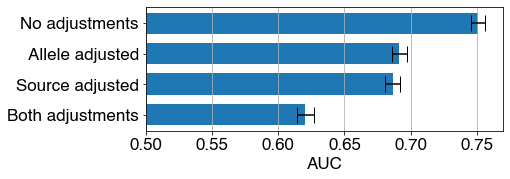

In [138]:
selected_model_shortcuts = TransformerSourceDaGRL64DimLr_Experiment_results[0]
vis_results = [
    ('No adjustments', 'MHC I+II - no MHC+source defaults/Validation', selected_model_shortcuts),
    ('Allele adjusted', 'MHC I+II - MHC corrected - no defaults/Validation', selected_model_shortcuts),
    ('Source adjusted', 'MHC I+II - source corrected - no defaults/Validation', selected_model_shortcuts),
    ('Both adjustments', 'MHC I+II - MHC+source corrected - no defaults/Validation', selected_model_shortcuts),        
]
hplot_results(vis_results, 'ROC AUC', '', (7.4, 2.8), 'mean', y_lim=(0.5, 0.77), display_sizes=False, err_text=True, display_text=False, strength=0.7)
plt.xlabel('AUC')
plt.savefig('../paper/figures/shortcut_evaluation_no_da.pdf', bbox_inches='tight')

# Figure 3 a) ADA Transformer performance

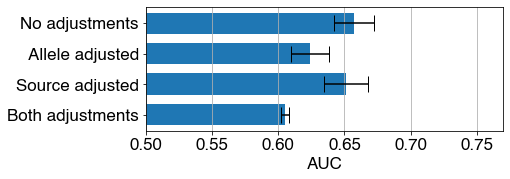

In [142]:
selected_model_shortcuts = TransformerSourceDaGRL64DimLr_Experiment_results[10]
vis_results = [
    ('No adjustments', 'MHC I+II - no MHC+source defaults/Validation', selected_model_shortcuts),
    ('Allele adjusted', 'MHC I+II - MHC corrected - no defaults/Validation', selected_model_shortcuts),
    ('Source adjusted', 'MHC I+II - source corrected - no defaults/Validation', selected_model_shortcuts),
    ('Both adjustments', 'MHC I+II - MHC+source corrected - no defaults/Validation', selected_model_shortcuts),        
]
hplot_results(vis_results, 'ROC AUC', '', (7.4, 2.8), 'mean', y_lim=(0.5, 0.77), display_sizes=False, err_text=True, display_text=False, strength=0.7)
plt.xlabel('AUC')
plt.savefig('../paper/figures/shortcut_evaluation_source_da.pdf', bbox_inches='tight')

# Figure 3 b) Prediction scores

In [188]:
import pickle

In [189]:
def get_prediction_scores(file, epoch):
    with open(file, 'rb') as f:
        prediction_dict = pickle.load(f)
        vaccinia_pos_min = prediction_dict['valid'][epoch]['Vaccinia pos']
        vaccinia_neg_maj = prediction_dict['valid'][epoch]['Vaccinia neg']
        betaherpes_pos_maj = prediction_dict['valid'][epoch]['Betaherpes pos']
        betaherpes_neg_min = prediction_dict['valid'][epoch]['Betaherpes neg']
        return vaccinia_pos_min, vaccinia_neg_maj, betaherpes_pos_maj, betaherpes_neg_min

In [190]:
vaccinia_pos_min, vaccinia_neg_maj, betaherpes_pos_maj, betaherpes_neg_min = get_prediction_scores('../visualization_data/DAVisPaper/prediction_scores_0.pkl', 190)

In [191]:
grl_vaccinia_pos_min, grl_vaccinia_neg_maj, grl_betaherpes_pos_maj, grl_betaherpes_neg_min = get_prediction_scores('../visualization_data/DAVisPaper/prediction_scores_1.pkl', 240)

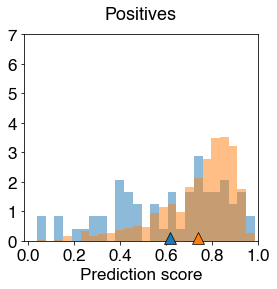

In [197]:
bins = np.linspace(0, 1.1, 30)
fig, ax = plt.subplots(figsize=(4.2, 3.8))
ax.set_ylim([0, 7])
ax.set_xlim([-0.02, 1])
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.])
ax.set_yticks(range(8))

ax.hist(vaccinia_pos_min, bins, alpha=0.5, label='Minority', density=True)
ax.hist(betaherpes_pos_maj, bins, alpha=0.5, label='Majority', density=True)

marker_1 = ax.plot([np.mean(vaccinia_pos_min),], [0.1,], '^', markersize=12, markeredgewidth=0.7, markeredgecolor='black', color='tab:blue', clip_on=False, zorder=10)[0]
marker_2 = ax.plot([np.mean(betaherpes_pos_maj),], [0.1,], '^', markersize=12, markeredgewidth=0.7, markeredgecolor='black', color='tab:orange', clip_on=False, zorder=10)[0]
# plt.legend(loc='upper center', fontsize=16)
plt.xlabel('Prediction score')
# plt.ylabel('Probability density')
plt.title('Positives', fontsize=18)
plt.savefig('../paper/figures/prediction_scores_wo_da_pos_3.pdf', bbox_inches='tight')

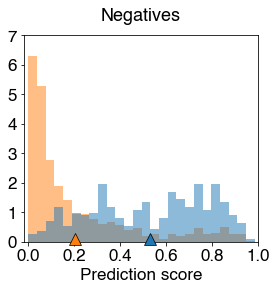

In [198]:
bins = np.linspace(0, 1.1, 30)
fig, ax = plt.subplots(figsize=(4.2, 3.8))
ax.set_ylim([0, 7])
ax.set_xlim([-0.02, 1])
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.])
ax.set_yticks(range(8))

plt.hist(vaccinia_neg_maj, bins, alpha=0.5, label='Majority', density=True, color='tab:orange')
plt.hist(betaherpes_neg_min, bins, alpha=0.5, label='Minority', density=True, color='tab:blue')
marker_1 = ax.plot([np.mean(vaccinia_neg_maj),], [0.1,], '^', markersize=12, markeredgewidth=0.7, markeredgecolor='black', color='tab:orange', clip_on=False, zorder=10)[0]
marker_2 = ax.plot([np.mean(betaherpes_neg_min),], [0.1,], '^', markersize=12, markeredgewidth=0.7, markeredgecolor='black', color='tab:blue', clip_on=False, zorder=10)[0]
# plt.legend(fontsize=16)
plt.xlabel('Prediction score')
plt.title('Negatives', fontsize=18)
plt.savefig('../paper/figures/prediction_scores_wo_da_neg_3.pdf', bbox_inches='tight')

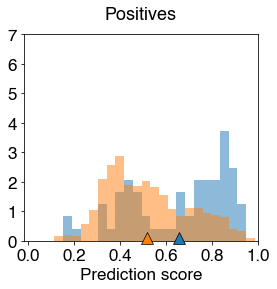

In [199]:
bins = np.linspace(0, 1.1, 30)
fig, ax = plt.subplots(figsize=(4.2, 3.8))
ax.set_ylim([0, 7])
ax.set_xlim([-0.02, 1])
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.])
ax.set_yticks(range(8))

plt.hist(grl_vaccinia_pos_min, bins, alpha=0.5, label='Minority', density=True)
plt.hist(grl_betaherpes_pos_maj, bins, alpha=0.5, label='Majority', density=True)

marker_1 = ax.plot([np.mean(grl_vaccinia_pos_min),], [0.1,], '^', markersize=12, markeredgewidth=0.7, markeredgecolor='black', color='tab:blue', clip_on=False, zorder=10)[0]
marker_2 = ax.plot([np.mean(grl_betaherpes_pos_maj),], [0.1,], '^', markersize=12, markeredgewidth=0.7, markeredgecolor='black', color='tab:orange', clip_on=False, zorder=10)[0]
# plt.legend(loc='upper center', fontsize=16)
plt.xlabel('Prediction score')
plt.title('Positives', fontsize=18)
plt.savefig('../paper/figures/prediction_scores_da_pos_3.pdf', bbox_inches='tight')

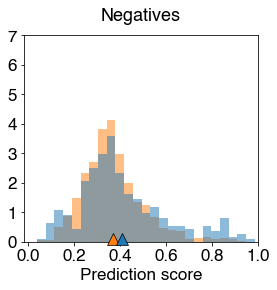

In [200]:
bins = np.linspace(0, 1.1, 30)
fig, ax = plt.subplots(figsize=(4.2, 3.8))
ax.set_ylim([0, 7])
ax.set_xlim([-0.02, 1])
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.])
ax.set_yticks(range(8))

plt.hist(grl_vaccinia_neg_maj, bins, alpha=0.5, label='Majority', density=True, color='tab:orange')
plt.hist(grl_betaherpes_neg_min, bins, alpha=0.5, label='Minority', density=True, color='tab:blue')

marker_1 = ax.plot([np.mean(grl_vaccinia_neg_maj),], [0.1,], '^', markersize=12, markeredgewidth=0.7, markeredgecolor='black', color='tab:orange', clip_on=False, zorder=10)[0]
marker_2 = ax.plot([np.mean(grl_betaherpes_neg_min),], [0.1,], '^', markersize=12, markeredgewidth=0.7, markeredgecolor='black', color='tab:blue', clip_on=False, zorder=10)[0]
# plt.legend(loc='upper center', fontsize=16)
plt.xlabel('Prediction score')
plt.title('Negatives', fontsize=18)
plt.savefig('../paper/figures/prediction_scores_da_neg_3.pdf', bbox_inches='tight')

# Figure 4 a)

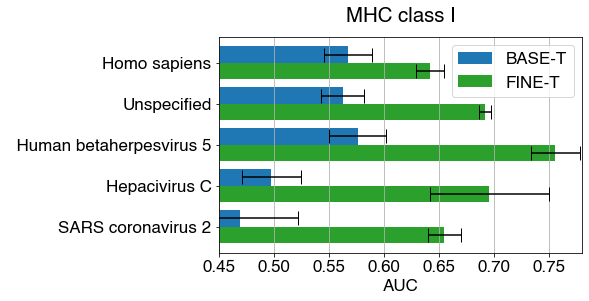

In [187]:
result_labels = ['Homo sapiens', 'unknown', 'Human betaherpesvirus 5', 'Hepacivirus C', 'Severe acute respiratory syndrome coronavirus 2']
result_labels_short = ['Homo sapiens', 'Unspecified', '  Human betaherpesvirus 5', 'Hepacivirus C', 'SARS coronavirus 2']

metric_string = 'MHC I - MHC corrected - no defaults/Validation'
vis_results_multi_source = ([('', f'MHC I - {source}/Validation', TransformerMultiSourcePaperValidRe_results) for source in result_labels], 'BASE-T')
vis_results_pretraining = ([('', metric_string, TransformerPretrainedOneSourcePaperValidReI_results[source]) for source in result_labels], 'FINE-T')


hplot_results_pairs(vis_results_multi_source, vis_results_pretraining, result_labels_short, 'ROC AUC', 'MHC class I', (8.5, 4.5), 'mean', x_pos=None, y_lim=(0.45, 0.78), err_text=True, display_text=False, legend=True)
plt.xlabel('AUC')
plt.savefig('../paper/figures/valid_multi_source_base_pre_I_fine.pdf', bbox_inches='tight')

# Figure 4 b)

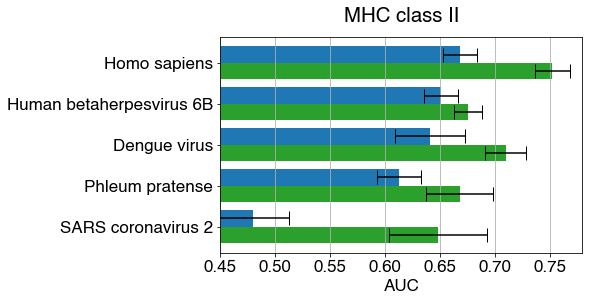

In [185]:
result_labels = ['Homo sapiens', 'Human betaherpesvirus 6B', 'Dengue virus', 'Phleum pratense', 'Severe acute respiratory syndrome coronavirus 2']
result_labels_short = ['Homo sapiens', 'Human betaherpesvirus 6B', 'Dengue virus', 'Phleum pratense', 'SARS coronavirus 2']

metric_string = 'MHC II - MHC corrected - no defaults/Validation'
vis_results_multi_source = ([('', f'MHC II - {source}/Validation', TransformerMultiSourcePaperValidRe_results) for source in result_labels], 'Multi-source')
vis_results_pretraining = ([('', metric_string, TransformerPretrainedOneSourcePaperValidReII_results[source]) for source in result_labels], 'With pretraining')

hplot_results_pairs(vis_results_multi_source, vis_results_pretraining, result_labels_short, 'ROC AUC', 'MHC class II', (8.5, 4.5), 'mean', x_pos=None, y_lim=(0.45, 0.78), err_text=True, display_text=False, legend=False)
plt.xlabel('AUC')
plt.savefig('../paper/figures/valid_multi_source_base_pre_II_fine.pdf', bbox_inches='tight')

# Figure 5 - Human peptides test performance

In [8]:
def load_test_data(model_name, results_dir):
    prediction_df_list = []
    for i in range(5):
        prediction_df = pd.read_csv(f'../{results_dir}/{model_name}/test_outer_{i}.csv', index_col=0, low_memory=False)
        prediction_df_list.append((i, prediction_df))
    return prediction_df_list

In [153]:
netmhc_prediction_df_list = load_test_data('ExternalTest', 'test_results')
NetMHC_I_predictions_merged = pd.read_csv('NetMHC_I_predictions_merged.csv', index_col=False, low_memory=False)
NetMHC_II_predictions_merged = pd.read_csv('NetMHC_II_predictions_merged.csv', index_col=False, low_memory=False)
netmhc_dict = {'I': {}, 'II': {}}
for peptide, peptide_df in NetMHC_I_predictions_merged.groupby(['peptide']):
    netmhc_dict['I'][peptide] = peptide_df['percentile_rank'].min()
for peptide, peptide_df in NetMHC_II_predictions_merged.groupby(['peptide']):
    netmhc_dict['II'][peptide] = peptide_df['percentile_rank'].min()

In [93]:
def evaluate_test_NetMHC_predictions(model_name, description='Test', results_dir='test_results', custom_eval_options=None, per_fold=False):
    prediction_df_list = load_test_data(model_name, results_dir)
    if custom_eval_options is not None:
        results_list = [{**get_custom_evaluation_dict(get_NetMHC_predictions(prediction_df, netmhc_dict), description, custom_eval_options), 'outer_fold': fold_id} for fold_id, prediction_df in prediction_df_list]
    else:
        results_list = [{**get_evaluation_dict(get_NetMHC_predictions(prediction_df, netmhc_dict), description), 'outer_fold': fold_id} for fold_id, prediction_df in prediction_df_list]
    
    if per_fold:
        return results_list
    
    combined_results = combine_fold_results(results_list)
    test_results = [combined_results]
    return test_results

In [94]:
def get_NetMHC_predictions(prediction_df, netmhc_dict):
    # prediction_df['Prediction'] = - prediction_df['MHC Allele Prediction - Min Percentile Rank']
    prediction_df['Prediction'] = - prediction_df.apply(lambda x: netmhc_dict[x["MHC Class"]][x['Epitope Description']], axis=1)
    return prediction_df

In [27]:
def get_prime_predictions():
    prime_predictions_1 = pd.read_csv(f'prime/prime_sequences_all_1.txt', index_col=False, low_memory=False, sep='\t')
    prime_predictions_2 = pd.read_csv(f'prime/prime_sequences_all_2.txt', index_col=False, low_memory=False, sep='\t')
    prime_predictions_3 = pd.read_csv(f'prime/prime_sequences_all_3.txt', index_col=False, low_memory=False, sep='\t')

    combined_alleles_pred = pd.concat([prime_predictions_1['Score_bestAllele'], prime_predictions_2['Score_bestAllele'], prime_predictions_3['Score_bestAllele']], axis=1).max(axis=1)

    prime_predictions_1['external_score'] = combined_alleles_pred
    prime_predictions_1['external_peptide'] = prime_predictions_1['Peptide']
    return prime_predictions_1

In [28]:
def get_cd4episcore_predictions():
    cd4_predictions = pd.read_csv(f'cd4epi/CD4episcore.csv', index_col=False, low_memory=False, sep=',')

    cd4_predictions['external_score'] = - cd4_predictions['Combined_Score']
    cd4_predictions['external_peptide'] = cd4_predictions['peptide']
    return cd4_predictions

In [29]:
def get_external_prediction_lists(external_predictions, df_list):
    prediction_df_list = []
    for fold_id, prediction_df in df_list:
        merged_pred_df = prediction_df.merge(external_predictions, left_on='Epitope Description', right_on='external_peptide')
        merged_pred_df['Prediction'] = merged_pred_df['external_score']
        prediction_df_list.append((fold_id, merged_pred_df))
    return prediction_df_list

In [30]:
def get_external_prediction_performance(prediction_df_list, description, per_fold=False):
    results_list_ext = [{**get_evaluation_dict(prediction_df, description), 'outer_fold': fold_id} for fold_id, prediction_df in prediction_df_list]
    
    if per_fold:
        return results_list_ext
    
    combined_results_ext = combine_fold_results(results_list_ext)
    return combined_results_ext

In [154]:
NetMHC_test = evaluate_test_NetMHC_predictions('ExternalTest')

In [ ]:
external_df_list_test = load_test_data('ExternalTest', 'test_results')

In [104]:
# CD4Episcore 17% skipped peptides because they were too short (less than 15)
cd4episcore_predictions = get_cd4episcore_predictions()
cd4episcore_prediction_test_df_list = get_external_prediction_lists(cd4episcore_predictions, external_df_list_test)
cd4episcore_test = get_external_prediction_performance(cd4episcore_prediction_test_df_list, 'Test')

In [102]:
# Prime: 7 % skipped peptides because they were too long (more than 14)
external_df_list_test = load_test_data('ExternalTest', 'test_results')
prime_predictions = get_prime_predictions()
prime_prediction_test_df_list = get_external_prediction_lists(prime_predictions, external_df_list_test)
PRIME_test = get_external_prediction_performance(prime_prediction_test_df_list, 'Test')

In [108]:
# Bag-Of-AA
BagOfAAHumanNCV_I = read_test_results('BagOfAAHumanNCV_I')
BagOfAAHumanNCV_I_test_results = combine_test_results(BagOfAAHumanNCV_I)
BagOfAAHumanNCV_II = read_test_results('BagOfAAHumanNCV_II')
BagOfAAHumanNCV_II_test_results = combine_test_results(BagOfAAHumanNCV_II)

In [ ]:
# FINE-T
TransformerPretrainedHumanPaper_I_II_pre_I_data = read_test_results('TransformerPretrainedHumanPaper_I_II_pre_I_data')
TransformerPretrainedHumanPaper_I_II_pre_I_data_test_results = combine_test_results(TransformerPretrainedHumanPaper_I_II_pre_I_data)
TransformerPretrainedHumanPaper_I_II_pre_II_data = read_test_results('TransformerPretrainedHumanPaper_I_II_pre_II_data')
TransformerPretrainedHumanPaper_I_II_pre_II_data_test_results = combine_test_results(TransformerPretrainedHumanPaper_I_II_pre_II_data)

In [115]:
def hplot_test_results(results, metric, title, size, aggregation='mean', x_pos=None, y_lim=None, err_bars=True, err_text=False, label_rotation=0, text_shift=0.005, vline=None, display_sizes=True, display_text=True, color=None, strength=0.8, hide_xticklabels=False):
    results_r = list(reversed(results))
    # results = [(x_label, eval_type, results_dict), ...]
    x_pos = list(range(len(results_r))) if x_pos is None else x_pos
    if display_sizes:
        x_labels = [f"{x_label} - {result[metric][eval_type]['skipped_count']/(result[metric][eval_type]['skipped_count']+result[metric][eval_type]['count']):.0%} skipped" for x_label, eval_type, result in results_r]
    else:
        x_labels = [f"{x_label}" for x_label, eval_type, result in results_r]
        skipped_count_sum = sum([result[metric][eval_type]['skipped_count'] for _, eval_type, result in results_r if 'skipped_count' in result[metric][eval_type]])
        if skipped_count_sum > 0:
            # print(f'{skipped_count_sum} peptides have been skipped.')
            pass
    mean_scores = [results_dict[metric][eval_type][aggregation] for _, eval_type, results_dict in results_r]
    mean_scores_fold = [results_dict[metric][eval_type]['fold_0'] for _, eval_type, results_dict in results_r]
    errs = [results_dict[metric][eval_type]['sem'] for _, eval_type, results_dict in results_r] if err_bars else None
    fig, ax = plt.subplots(figsize=size)
    ax.barh(x_pos, mean_scores, height=strength, xerr=errs, align='center', alpha=1, ecolor='0.2', capsize=11, color='0.8', label='All CV test sets')
    ax.barh(x_pos, mean_scores_fold, height=strength*0.5, xerr=None, align='center', alpha=1, ecolor='black', capsize=8, color='tab:blue', label='Holdout test set')
    ax.set_xlabel(metric)
    ax.set_yticks(x_pos)
    ax.set_yticklabels(x_labels, rotation=label_rotation)
    if hide_xticklabels:
        ax.set_xticks([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7])
        ax.set_xticklabels([])
    else:
        ax.set_xticks([0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7])
        ax.set_xticklabels(['0.4', '0.45', '0.5', '0.55', '0.6', '0.65', '0.7'])
    ax.set_title(title)
    if metric == 'ROC AUC' and y_lim is None:
        ax.set_xlim(0.4, 0.9)
    elif y_lim is None:
        ax.set_xlim(0, 0.9)
    else:
        ax.set_xlim(y_lim)
    ax.xaxis.grid(True)
    
    if vline is not None:
        plt.axvline(x=vline, color='black', linewidth=1)
    plt.tight_layout()
    # plt.show()

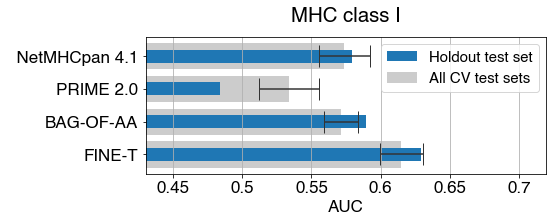

In [168]:
vis_results_test = [
    ('  NetMHCpan 4.1', 'MHC I - MHC corrected - Human - no defaults/Test', NetMHC_test[0]),
    ('PRIME 2.0', 'MHC I - MHC corrected - Human subset - no defaults/Test', PRIME_test),
    ('BAG-OF-AA', 'MHC I - MHC corrected - Human - no defaults/Test', BagOfAAHumanNCV_I_test_results),
    ('FINE-T', 'MHC I - MHC corrected - Human - no defaults/Test', TransformerPretrainedHumanPaper_I_II_pre_I_data_test_results),
]

hplot_test_results(vis_results_test, 'ROC AUC', 'MHC class I', (8, 3.4), f'mean', x_pos=None, y_lim=(0.43, 0.72), err_bars=True, err_text=True, display_text=False, display_sizes=False, color='tab:blue', hide_xticklabels=False)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=15)
# plt.tight_layout()
plt.xlabel('AUC')
plt.savefig('../paper/figures/human_roc_holdout_I.pdf', bbox_inches='tight')

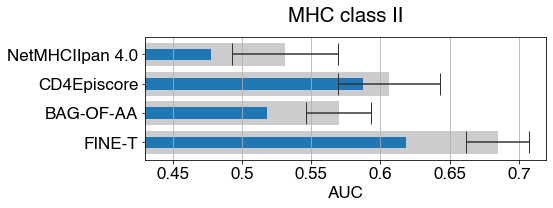

In [169]:
vis_results_test = [
    ('NetMHCIIpan 4.0', 'MHC II - MHC corrected - Human - no defaults/Test', NetMHC_test[0]),
    ('CD4Episcore', 'MHC II - MHC corrected - Human subset - no defaults/Test', cd4episcore_test),
    ('BAG-OF-AA', 'MHC II - MHC corrected - Human - no defaults/Test', BagOfAAHumanNCV_II_test_results),
    ('FINE-T', 'MHC II - MHC corrected - Human - no defaults/Test', TransformerPretrainedHumanPaper_I_II_pre_II_data_test_results),
]

hplot_test_results(vis_results_test, 'ROC AUC', 'MHC class II', (8, 3.2), 'mean', x_pos=None, y_lim=(0.43, 0.72), err_bars=True, err_text=True, display_text=False, display_sizes=False, hide_xticklabels=False)
plt.xlabel('')
# plt.tight_layout()
plt.xlabel('AUC')
plt.savefig('../paper/figures/human_roc_holdout_II.pdf', bbox_inches='tight')

# Supplement S4 Negative Transfer - Validation

In [ ]:
def combine_individual_model_results_es(model_results, mhc_string=''):
    # this version does not require eval strings with sources/alleles specified
    # like "ROC AUC{mhc_string} - {allele}"
    fold_results = []
    for fold in range(4):
        roc_auc_per_allele = []
        counts_per_allele = []
        for allele in model_results.keys():
            if allele in ['All', 'MHC Class I', 'MHC Class I+II', 'MHC Class II']:
                continue
            count_per_allele_per_fold = model_results[allele]['seed_avg_df']['Count - ROC AUC - MHC I+II - MHC+source corrected - no defaults/Validation'].iloc[fold]
            counts_per_allele.append(count_per_allele_per_fold)
            roc_auc_per_allele_per_fold = model_results[allele]['seed_avg_df'][f'ROC AUC - MHC I+II - MHC+source corrected - no defaults/Validation'].iloc[fold]
            roc_auc_per_allele.append(roc_auc_per_allele_per_fold)
        roc_auc_combined = sum([roc_auc_per_allele[i]*counts_per_allele[i] for i in range(len(roc_auc_per_allele))]) / sum(counts_per_allele)
        fold_results.append(roc_auc_combined)
    
    overall_count = sum(counts_per_allele)
    mean_roc_auc = np.mean(fold_results)
    sem_roc_auc = scipy.stats.sem(fold_results)
    
    result_dict = {'ROC AUC': {'Combined results': {'mean': mean_roc_auc, 'sem': sem_roc_auc, 'count': overall_count, 'skipped_count': 0}}}
    return result_dict

In [41]:
TransformerMHCAllelesPaperMaEs10 = read_valid_results('TransformerMHCAllelesPaperMaEs10')
TransformerMHCAllelesPaperMaEs10_results = get_inner_cv_results(TransformerMHCAllelesPaperMaEs10,
                                                       average_over=['random_seed', 'batch_size'],
                                                       group_by='select_alleles')

In [133]:
combined_allele_paper_results_ma_10_es = combine_individual_model_results_es(TransformerMHCAllelesPaperMaEs10_results)

In [42]:
TransformerPeptideSourcesPaperMaEs10 = read_valid_results('TransformerPeptideSourcesPaperMaEs10')
TransformerPeptideSourcesPaperMaEs10_results = get_inner_cv_results(TransformerPeptideSourcesPaperMaEs10,
                                                           average_over=['random_seed', 'batch_size'],
                                                           group_by='select_pep_sources')

In [134]:
combined_source_paper_ma_10_results = combine_individual_model_results_es(TransformerPeptideSourcesPaperMaEs10_results, ' - MHC I+II')

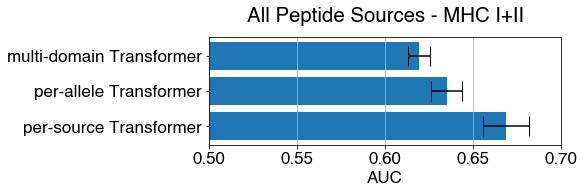

In [392]:
vis_results = [
    ('multi-domain Transformer', 'MHC I+II - MHC+source corrected - no defaults/Validation', TransformerPeptideSourcesPaperMaEs10_results['All']),
    ('per-allele Transformer', 'Combined results', combined_allele_paper_results_ma_10_es),
    ('per-source Transformer', 'Combined results', combined_source_paper_ma_10_results),
]
hplot_results(vis_results, 'ROC AUC', 'All Peptide Sources - MHC I+II', (8.5, 3), 'mean', y_lim=(0.5, 0.7), display_sizes=False, err_text=False, display_text=False)
plt.xlabel('AUC')
plt.savefig('../paper/figures/negative_transfer.pdf', bbox_inches='tight')

# Supplement S5 Ablation study for FINE-T

In [171]:
TransformerMultiSourcePaperValidRe = read_valid_results('TransformerMultiSourcePaperValidRe')
TransformerMultiSourcePaperValidRe_results = get_inner_cv_results(TransformerMultiSourcePaperValidRe,
                                                       average_over=['random_seed'])

In [173]:
TransformerOneSourcePaperValidReI = read_valid_results('TransformerOneSourcePaperValidReI')
TransformerOneSourcePaperValidReI_results = get_inner_cv_results(TransformerOneSourcePaperValidReI,
                                                       average_over=['random_seed', 'batch_size'],
                                                       group_by='select_pep_sources')

In [175]:
TransformerOneSourcePaperValidReII = read_valid_results('TransformerOneSourcePaperValidReII')
TransformerOneSourcePaperValidReII_results = get_inner_cv_results(TransformerOneSourcePaperValidReII,
                                                       average_over=['random_seed', 'batch_size'],
                                                       group_by='select_pep_sources')

In [177]:
TransformerPretrainedOneSourcePaperValidReI = read_valid_results('TransformerPretrainedOneSourcePaperValidReI')
TransformerPretrainedOneSourcePaperValidReI_results = get_inner_cv_results(TransformerPretrainedOneSourcePaperValidReI,
                                                       average_over=['random_seed', 'batch_size'],
                                                       group_by='pep_source_train_selection')

In [179]:
TransformerPretrainedOneSourcePaperValidReII = read_valid_results('TransformerPretrainedOneSourcePaperValidReII')
TransformerPretrainedOneSourcePaperValidReII_results = get_inner_cv_results(TransformerPretrainedOneSourcePaperValidReII,
                                                       average_over=['random_seed', 'batch_size'],
                                                       group_by='pep_source_train_selection')

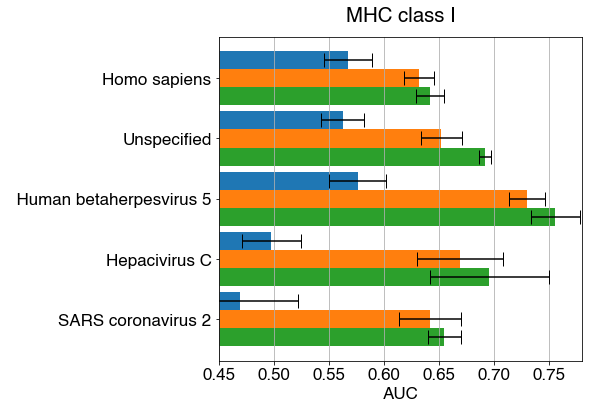

In [510]:
result_labels = ['Homo sapiens', 'unknown', 'Human betaherpesvirus 5', 'Hepacivirus C', 'Severe acute respiratory syndrome coronavirus 2']
result_labels_short = ['Homo sapiens', 'Unspecified', '  Human betaherpesvirus 5', 'Hepacivirus C', 'SARS coronavirus 2']

metric_string = 'MHC I - MHC corrected - no defaults/Validation'
vis_results_multi_source = ([('', f'MHC I - {source}/Validation', TransformerMultiSourcePaperValidRe_results) for source in result_labels], 'Multi-source')
vis_results = ([('', metric_string, TransformerOneSourcePaperValidReI_results[source]) for source in result_labels], 'Without pretraining')
vis_results_pretraining = ([('', metric_string, TransformerPretrainedOneSourcePaperValidReI_results[source]) for source in result_labels], 'With pretraining')

hplot_results_triples(vis_results_multi_source, vis_results, vis_results_pretraining, result_labels_short, 'ROC AUC', 'MHC class I', (8.5, 6), 'mean', x_pos=None, y_lim=(0.45, 0.78), err_text=True, display_text=False, legend=False)
plt.xlabel('AUC')
plt.savefig('../paper/figures/valid_multi_source_I.pdf', bbox_inches='tight')

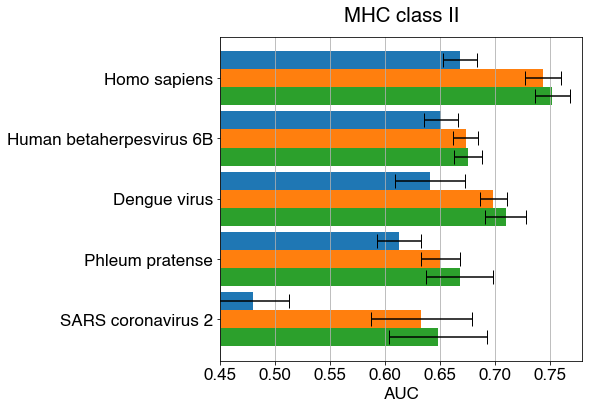

In [511]:
result_labels = ['Homo sapiens', 'Human betaherpesvirus 6B', 'Dengue virus', 'Phleum pratense', 'Severe acute respiratory syndrome coronavirus 2']
result_labels_short = ['Homo sapiens', 'Human betaherpesvirus 6B', 'Dengue virus', 'Phleum pratense', 'SARS coronavirus 2']

metric_string = 'MHC II - MHC corrected - no defaults/Validation'
vis_results_multi_source = ([('', f'MHC II - {source}/Validation', TransformerMultiSourcePaperValidRe_results) for source in result_labels], 'Multi-source')
vis_results = ([('', metric_string, TransformerOneSourcePaperValidReII_results[source]) for source in result_labels], 'Without pretraining')
vis_results_pretraining = ([('', metric_string, TransformerPretrainedOneSourcePaperValidReII_results[source]) for source in result_labels], 'With pretraining')


hplot_results_triples(vis_results_multi_source, vis_results, vis_results_pretraining, result_labels_short, 'ROC AUC', 'MHC class II', (8.5, 6), 'mean', x_pos=None, y_lim=(0.45, 0.78), err_text=True, display_text=False, legend=False)
plt.xlabel('AUC')
plt.savefig('../paper/figures/valid_multi_source_II.pdf', bbox_inches='tight')

# Supplement S6 Permutation experiment with FINE-T

In [562]:
def plot_permutation_performance_2(permutation_results_df, no_permutation_results_df, mhc_class):
    ax = permutation_results_df.groupby(['random_seed']).mean()[f'ROC AUC - MHC {mhc_class} - MHC corrected - Human - no defaults/Test'].hist(bins=30)
    ax.set_xlabel('AUC')
    NoPermutationAUC = no_permutation_results_df
    marker = ax.plot([NoPermutationAUC,], [0,], '^', markersize=12, color='red', label='No permutations')[0]
    marker.set_clip_on(False)
    ax.legend(fontsize=14)
    ax.set_xlim(0.39, 0.7)
    ax.set_title(f'MHC {mhc_class}', fontsize=18)
    plt.savefig(f'../paper/figures/permutation_test_{mhc_class}.pdf', bbox_inches='tight')

In [281]:
TransformerPretrainedOneSourcePaperPermIHuman = read_test_results('TransformerPretrainedOneSourcePaperPermIHuman')
TransformerPretrainedOneSourcePaperPermIIHuman = read_test_results('TransformerPretrainedOneSourcePaperPermIIHuman')

In [546]:
TransformerPretrainedHumanPaper_I_II_pre_I_data = read_test_results('TransformerPretrainedHumanPaper_I_II_pre_I_data')
TransformerPretrainedHumanPaper_I_II_pre_I_data_test_results = combine_test_results(TransformerPretrainedHumanPaper_I_II_pre_I_data)
NoPermutationAUC_I = TransformerPretrainedHumanPaper_I_II_pre_I_data_test_results['ROC AUC']['MHC I - MHC corrected - Human - no defaults/Test']['mean']

In [545]:
TransformerPretrainedHumanPaper_I_II_pre_II_data = read_test_results('TransformerPretrainedHumanPaper_I_II_pre_II_data')
TransformerPretrainedHumanPaper_I_II_pre_II_data_test_results = combine_test_results(TransformerPretrainedHumanPaper_I_II_pre_II_data)
NoPermutationAUC_II = TransformerPretrainedHumanPaper_I_II_pre_II_data_test_results['ROC AUC']['MHC II - MHC corrected - Human - no defaults/Test']['mean']

In [547]:
NoPermutationAUC_I, NoPermutationAUC_II

(0.6149573524821862, 0.6846788846865592)

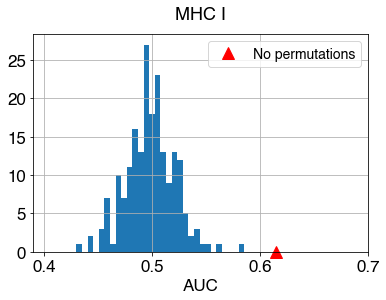

In [563]:
plot_permutation_performance_2(TransformerPretrainedOneSourcePaperPermIHuman, NoPermutationAUC_I, 'I')

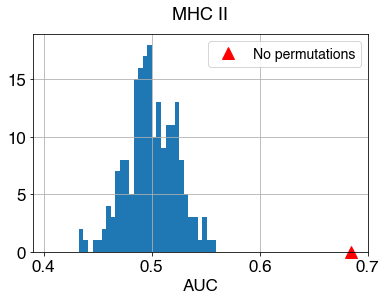

In [564]:
plot_permutation_performance_2(TransformerPretrainedOneSourcePaperPermIIHuman, NoPermutationAUC_II, 'II')